In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy

new_map = {'1, 50000': "#ffef40",
         '1, 70000': "#ff9f40",
         '1, 100000': "#ff6040",
         '2, 50000': "#6fff5c",
         '2, 70000': "#4ef5aa",
         '2, 100000': "#4ee1f5",
         '4, 50000': "#864ef5",
         '4, 70000': "#bb4ef5",
         '4, 1000000': "#ed5cdf",
          }

files = ['../../../data/out_metrics/results_20250111_230040_lay_act_0_4.pkl',
         '../../../data/out_metrics/results_20250110_235015_lay_act_4_8.pkl',
         '../../../data/out_metrics/results_20250111_141338_lay_act_8_12.pkl',
        '../../../data/out_metrics/results_20250111_073045_lay_act_12_16.pkl',
        '../../../data/out_metrics/results_20250113_231645_lay_act_15_16.pkl',
         '../../../data/out_metrics/results_20250112_141019_lay_act_16_20.pkl',
         '../../../data/out_metrics/results_20250113_032700_lay_act_20_24.pkl',
        ]

In [50]:
!ls ../../../data/out_metrics/results_2025*lay_act*0_4*

../../../data/out_metrics/results_20250108_023804_lay_act_0_4.pkl
../../../data/out_metrics/results_20250108_223518_lay_act_0_4.pkl
../../../data/out_metrics/results_20250110_035026_lay_act_0_4.pkl
../../../data/out_metrics/results_20250111_230040_lay_act_0_4.pkl


In [3]:
all_results = dict()
for file_name in files:
    with open(file_name, "rb") as file:
        results = dict(pickle.load(file))
    all_results = {**all_results, **results}
    
print(f"Amount of sets: {len(all_results)}")

# Flatten the data while preserving the structure from the tuple keys
flattened_data = {
    "activation_function": [],
    "num_layers": [],
    "n_rows": [],
    "iteration": [],
    "epochs": [],
    "accuracy": [],
    "capacity": []
}

# Iterate over each dataset size, activation function, and number of layers
for (n_rows, act_fn, n_layers), list_of_iterations in all_results.items():
    # For each iteration in the dataset size
    for i, iteration_list in enumerate(list_of_iterations):
        # Flatten the iteration list with epochs multiplied by 2 (0, 2, 4, ..., 18)
        for epoch, value in enumerate(iteration_list):
            cur_act_fn = act_fn
            if act_fn == 'default':
                cur_act_fn = "default"
            flattened_data["activation_function"].append(cur_act_fn)
            flattened_data["num_layers"].append(n_layers)
            flattened_data["n_rows"].append(n_rows)
            flattened_data["iteration"].append(i)
            flattened_data["epochs"].append((epoch+1) * 2)
            flattened_data["accuracy"].append(value)
            flattened_data["capacity"].append(int(value/100*n_rows))

# Convert to DataFrame for plotting
results_melted = pd.DataFrame(flattened_data)
results_melted.activation_function = results_melted.activation_function.apply(lambda x: {'default': "ReLU", 'GELU':'GELU', 'RAF':"RReLU", 'softmax':'softmax'}[x])
results_melted
# pd.DataFrame(all_results).T

Amount of sets: 24


,activation_function,num_layers,n_rows,iteration,epochs,accuracy,capacity
0,ReLU,1,50000,0,2,9.968000,4984
1,ReLU,1,50000,0,4,13.368000,6684
2,ReLU,1,50000,0,6,62.674000,31337
3,ReLU,1,50000,0,8,83.532000,41766
4,ReLU,1,50000,0,10,92.164000,46082
...,...,...,...,...,...,...,...
119995,softmax,4,70000,9,992,91.524286,64067
119996,softmax,4,70000,9,994,91.560000,64092
119997,softmax,4,70000,9,996,91.565714,64096
119998,softmax,4,70000,9,998,91.604286,64122


In [4]:
def draw_acc_epochs(
    results_melted,
    cur_cutoff,
    layer_color_map,
    x="epochs",
    y="accuracy",
    xlabel="Epochs",
    ylabel="Accuracy, %",
    title="Mean accuracy with standard deviation per epoch of training\nfor different data sizes, activation functions, and layers amount",
):
    cur_results_melted = results_melted[results_melted.epochs <= cur_cutoff].rename(
        columns={
            "n_rows": "data size",
            "n_rows, num_layers": "data size, layers amount",
            "activation_function": "activation function",
        }
    )

    # Plot with Seaborn
    sns.set(style="whitegrid")
    plt.figure(figsize=(9, 5))

    sns.lineplot(
        data=cur_results_melted,
        x=x,
        y=y,
        hue="data size, layers amount",  # Combined hue for Num_Layers and N_rows
        style="activation function",
        palette=layer_color_map,  # Ensure this supports the combined categories
        linewidth=1,
    )

    plt.xlim(0, cur_cutoff)

    # Add labels and legend
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(title="Configuration", bbox_to_anchor=(1.05, 1), loc="upper left")

    # Show the plot
    plt.tight_layout()
    plt.show()

In [5]:
# Generate unique colors for each Num_Layers value
unique_layers = results_melted['num_layers'].unique()
layer_palette = sns.color_palette("Set2", len(unique_layers))
layer_color_map = {layer: color for layer, color in zip(unique_layers, layer_palette)}

results_melted['n_rows, num_layers'] = results_melted['num_layers'].astype(str) + ", " + results_melted['n_rows'].astype(str)  
unique_hues = sorted(results_melted['n_rows, num_layers'].unique())
layer_color_map = {hue: sns.color_palette("Paired")[i % 10] for i, hue in enumerate(unique_hues)}


30


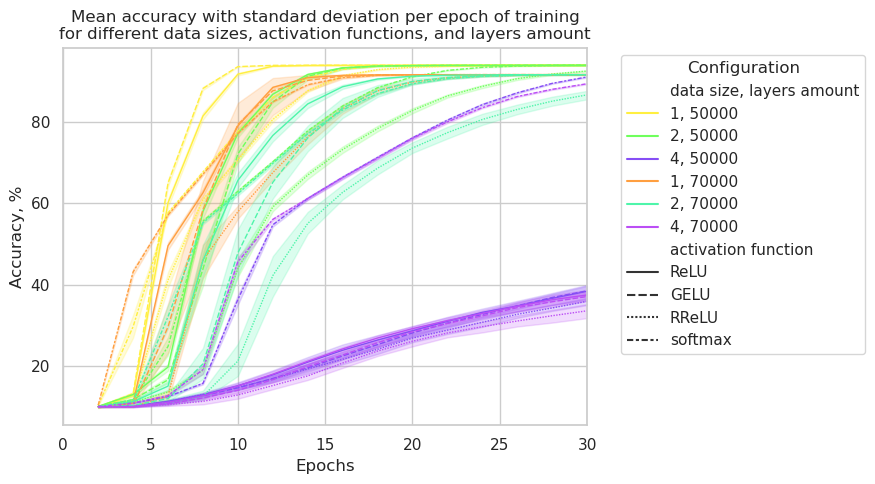

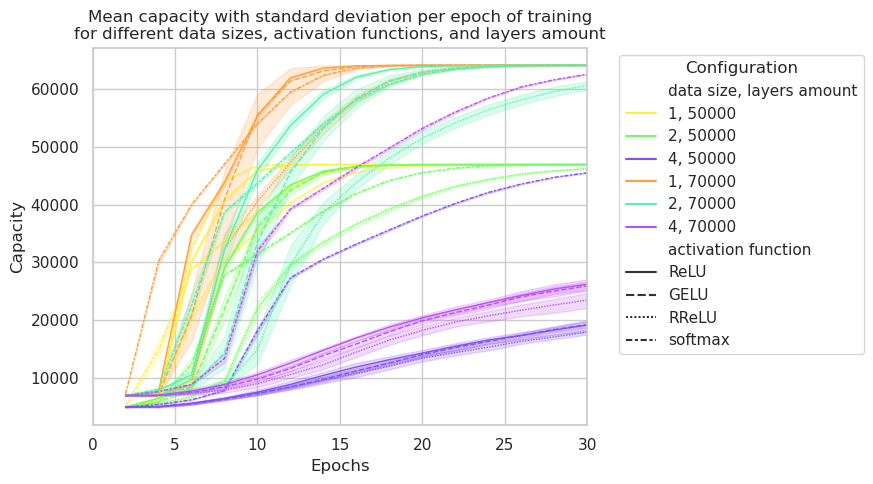

100


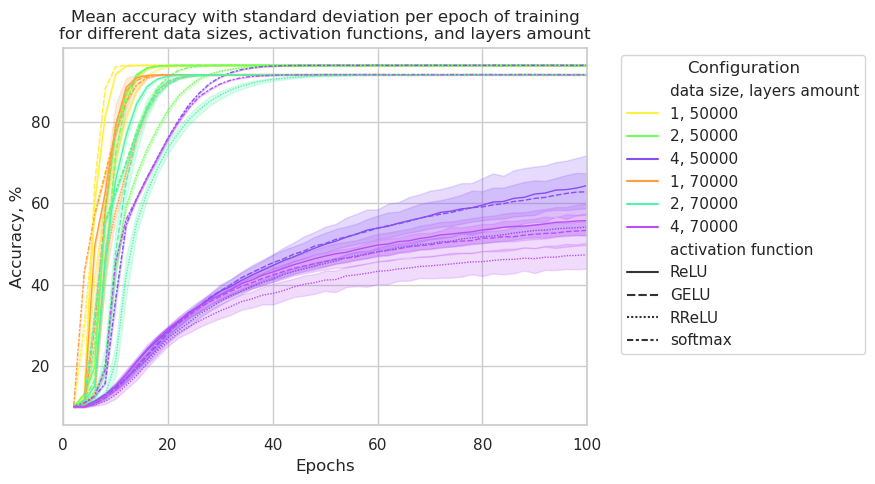

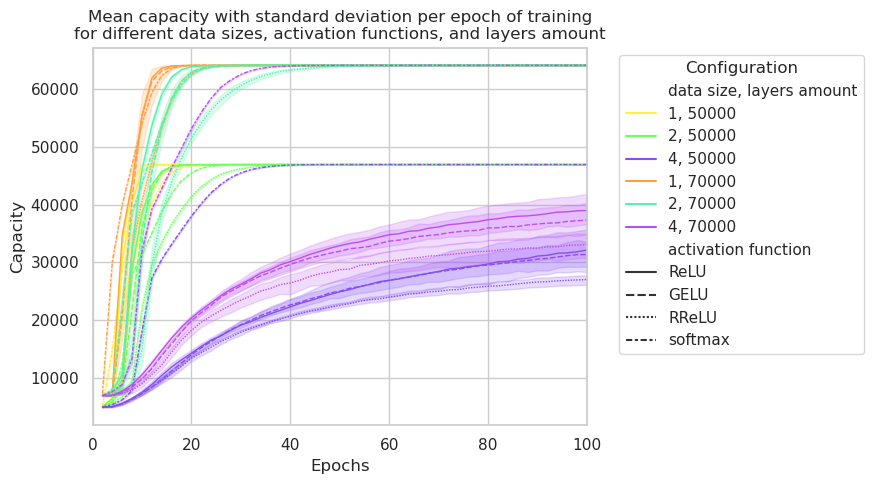

1000


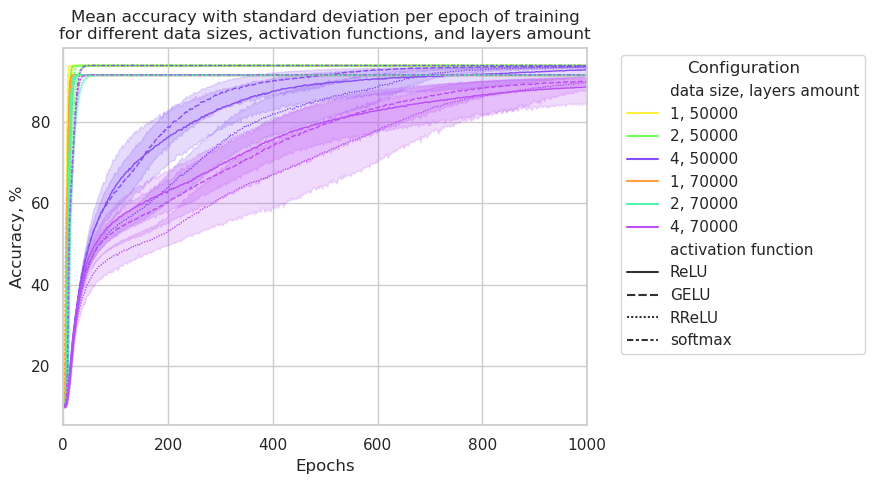

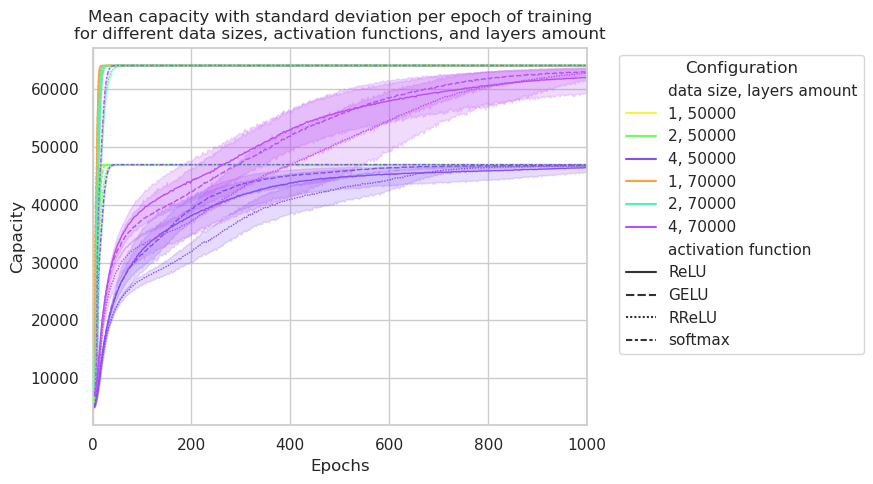

In [14]:
for epochs in [30, 100, results_melted.epochs.max()]:
    print(epochs)
    draw_acc_epochs(
        results_melted,
        epochs,
        new_map,
        x="epochs",
        y="accuracy",
        xlabel="Epochs",
        ylabel="Accuracy, %",
        title="Mean accuracy with standard deviation per epoch of training\nfor different data sizes, activation functions, and layers amount",
    )
    draw_acc_epochs(
        results_melted,
        epochs,
        new_map,
        x="epochs",
        y="capacity",
        xlabel="Epochs",
        ylabel="Capacity",
        title="Mean capacity with standard deviation per epoch of training\nfor different data sizes, activation functions, and layers amount",
    )

## Violins

In [6]:
data_viol = results_melted[results_melted.epochs == max(results_melted.epochs)]
data_viol.head()

,activation_function,num_layers,n_rows,iteration,epochs,accuracy,capacity,"n_rows, num_layers"
499,ReLU,1,50000,0,1000,93.752,46875,"1, 50000"
999,ReLU,1,50000,1,1000,93.964,46982,"1, 50000"
1499,ReLU,1,50000,2,1000,93.756,46878,"1, 50000"
1999,ReLU,1,50000,3,1000,93.958,46979,"1, 50000"
2499,ReLU,1,50000,4,1000,93.458,46729,"1, 50000"


In [46]:
temp = deepcopy(data_viol)
temp.activation_function = 'all'

df = pd.concat([data_viol, temp]).set_index(['activation_function','num_layers'])[['n_rows', 'accuracy', 'capacity']]
grouped = (
    df.groupby(['activation_function', 'num_layers', 'n_rows'])
    .agg(accuracy_mean=('accuracy', 'mean'),
         accuracy_std=('accuracy', 'std'),
         capacity_mean=('capacity', 'mean'),
         capacity_std=('capacity', 'std'))
)

# Unstack to pivot `n_rows` into columns
final = grouped.unstack(level='n_rows')

# Create a MultiIndex for columns with the correct order
final.columns = pd.MultiIndex.from_tuples(
    [(n_rows, metric) for metric, n_rows in final.columns],
    names=["n_rows", "metric"]
)
# ORDER cols
reordered_columns = sorted(final.columns, key=lambda x: x[0])  # Sort by the first level (n_rows)
final = final[reordered_columns]

# ORDER rows
# Define the desired order for 'activation_function'
activation_order = ['ReLU', 'GELU', 'RReLU', 'softmax', 'all']

# Reorder rows based on the activation function order
final = final.loc[activation_order]

# Rearrange columns: first all related to 50000, then 70000
reordered_columns = sorted(final.columns, key=lambda x: x[0])  # Sort by the first level (n_rows)
final = final[reordered_columns]


final

n_rows                                 50000                             \
metric                         accuracy_mean accuracy_std capacity_mean   
activation_function num_layers                                            
ReLU                1               93.79540     0.157627     46897.500   
                    2               93.84040     0.112051     46920.100   
                    4               92.78220     2.268083     46391.000   
GELU                1               93.84960     0.105619     46924.500   
                    2               93.85140     0.114543     46925.500   
                    4               93.59540     0.155798     46797.600   
RReLU               1               93.85960     0.124607     46929.800   
                    2               93.85300     0.121228     46926.500   
                    4               93.46020     0.223872     46729.900   
softmax             1               93.84760     0.086937     46923.700   
                    2               93.81620     0.126956     46908.000   
                    4               93.84720     0.104402     46923.400   
all                 1               93.83805     0.119493     46918.875   
                    2               93.84025     0.115143     46920.025   
                    4               93.42125     1.168848     46710.475   

n_rows                                              70000               \
metric                         capacity_std accuracy_mean accuracy_std   
activation_function num_layers                                           
ReLU                1             78.827872     91.558571     0.137462   
                    2             56.046508     91.551571     0.092595   
                    4           1133.988536     88.472857     6.056898   
GELU                1             52.722017     91.565714     0.131062   
                    2             57.275649     91.542429     0.085574   
                    4             78.040161     89.926857     1.361881   
RReLU               1             62.303558     91.543571     0.086973   
                    2             60.613988     91.554000     0.083630   
                    4            111.670597     89.739571     2.628955   
softmax             1             43.405197     91.546000     0.118289   
                    2             63.342105     91.535000     0.095367   
                    4             52.066624     91.549429     0.093324   
all                 1             59.731102     91.553464     0.115688   
                    2             57.543066     91.545750     0.086255   
                    4            584.380188     89.922179     3.423022   

n_rows                                                     
metric                         capacity_mean capacity_std  
activation_function num_layers                             
ReLU                1              64091.000    96.223120  
                    2              64085.700    64.884598  
                    4              61930.800  4240.090245  
GELU                1              64095.800    91.812369  
                    2              64079.600    59.909561  
                    4              62948.600   953.199664  
RReLU               1              64080.400    60.862687  
                    2              64087.800    58.541154  
                    4              62817.500  1840.142401  
softmax             1              64082.100    82.890088  
                    2              64074.300    66.999254  
                    4              64084.500    65.298035  
all                 1              64087.325    81.015474  
                    2              64081.850    60.459586  
                    4              62945.350  2396.201006

In [7]:
def draw_violins(
    data_viol, x, y, xlabel, ylabel, title, hue=None, return_ax=False, ax=None
):
    PALETTE_PARAMS = "Accent"
    PALETTE = "Set2"
    data_dict = {
        "x": x,
        "y": y,
        "palette": list(new_map.values())[::3],
        "alpha": 0.7,
        "linewidth": 0.5,
    }
    if hue:
        data_dict["hue"] = hue
        data_dict["dodge"] = True
    if ax:
        data_dict["ax"] = axs[col]
    ax = sns.stripplot(data_viol, **data_dict, legend=True)
    ax = sns.violinplot(
        data_viol,
        **data_dict,
        cut=0,
        legend=False,
    )

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if return_ax:
        return ax

All together


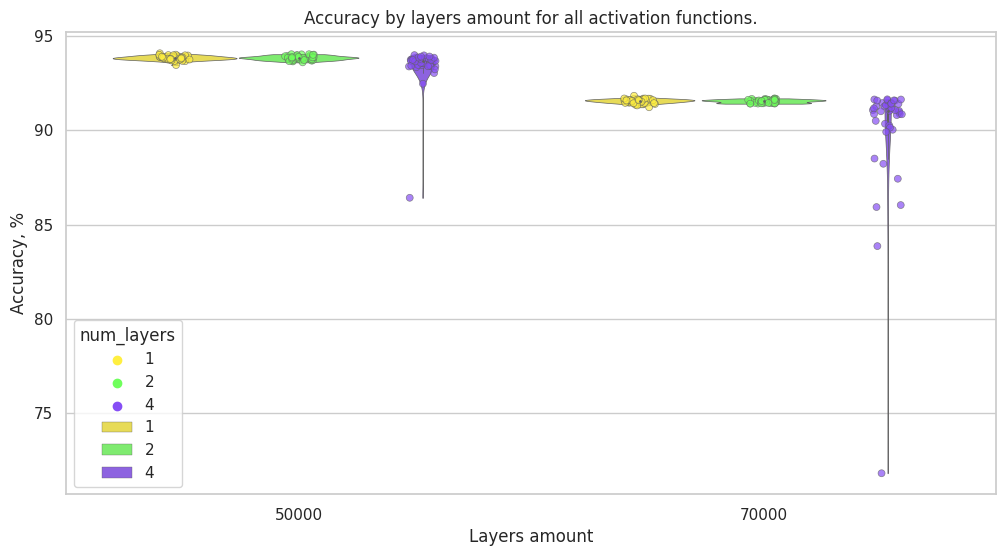

Separated


<Figure size 1400x400 with 0 Axes>

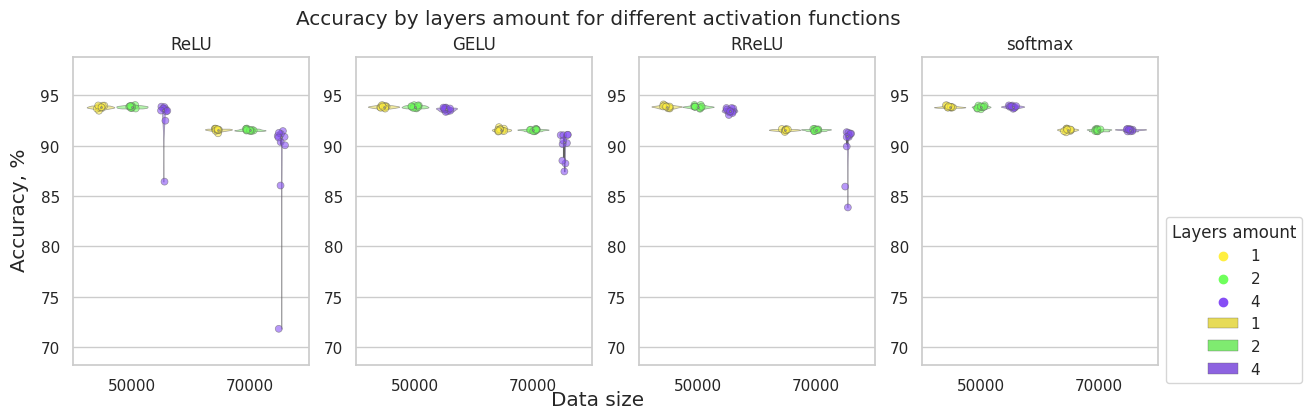

All together


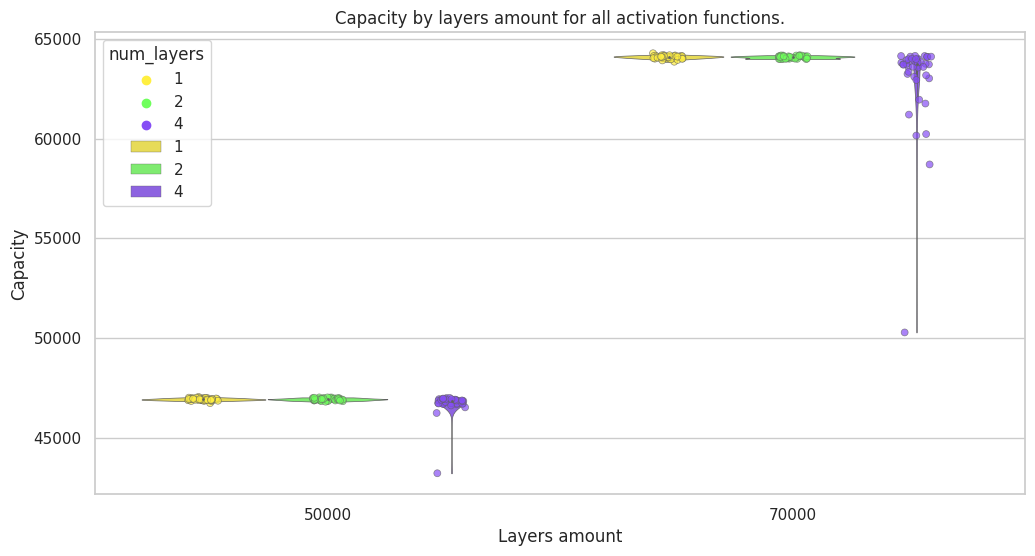

Separated


<Figure size 1400x400 with 0 Axes>

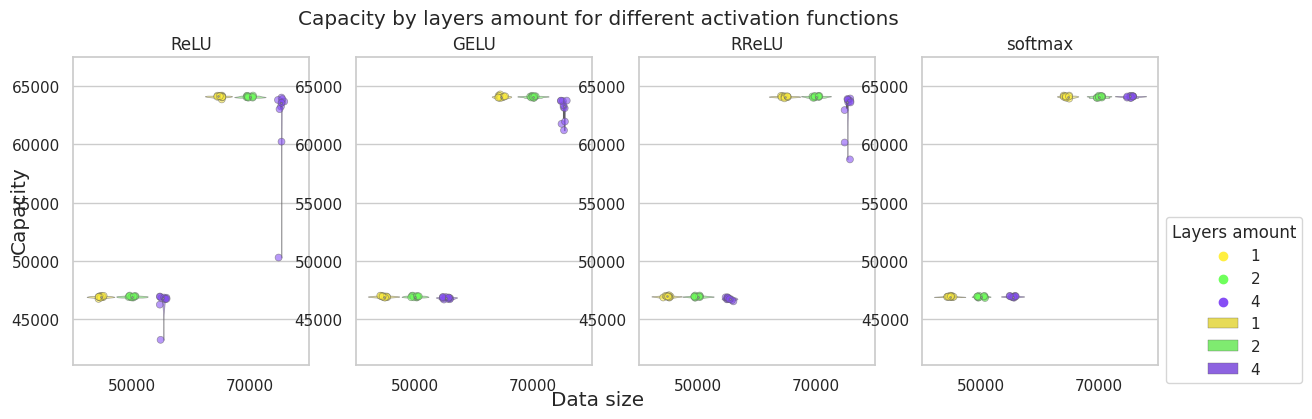

In [16]:
labels = [
    (
        "accuracy",
        "Accuracy, %",
        "Accuracy by layers amount for all activation functions.",
        "Accuracy by layers amount for different activation functions",
        (0, 100)
    ),
    (
        "capacity",
        "Capacity",
        "Capacity by layers amount for all activation functions.",
        "Capacity by layers amount for different activation functions",
        (0, 100000)
    ),
]


for y, ylabel, title, title_separated, val_range in labels:
    print("All together")
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 6))
    draw_violins(
        data_viol,
        x="n_rows",
        y=y,
        xlabel="Layers amount",
        ylabel=ylabel,
        title=title,
        hue="num_layers",
    )
    plt.show()
    # ==================================================
    print("Separated")
    sns.set(rc={"figure.figsize": (14, 4)})
    sns.set_theme(style="whitegrid")
    # get legend
    ax = draw_violins(
        data_viol,
        x="n_rows",
        y=y,
        xlabel="Layers amount",
        ylabel=ylabel,
        title=title_separated,
        hue="num_layers",
        return_ax=True,
    )
    handles, labels = ax.get_legend_handles_labels()
    plt.clf()
    # draw
    fig, axs = plt.subplots(nrows=1, ncols=4)
    for i, act_f in enumerate(data_viol.activation_function.unique()):
        row = i // 4
        col = i % 4
        cur_data = data_viol[data_viol.activation_function == act_f]
        ax = draw_violins(
            cur_data,
            x="n_rows",
            y=y,
            xlabel="Layers amount",
            ylabel=ylabel,
            title=f"`{act_f}`.",
            hue="num_layers",
            return_ax=True,
            ax=axs[col],
        )
        plt.setp(ax.collections, alpha=0.58)
        ax.legend_.remove()
        ax.set(ylabel="", xlabel="", title=act_f)
        ax.set(ylim=(data_viol[y].min()*0.95, data_viol[y].max()*1.05))
        ax
    fig.supylabel(ylabel, y=0.5, x=0.08)
    fig.supxlabel("Data size", y=0, x=0.5)
    fig.suptitle(title_separated, y=1, x=0.5)
    fig.legend(
        handles,
        labels,
        loc="upper left",
        bbox_to_anchor=(0.9, 0.5),
        title="Layers amount",
    )
    plt.subplots_adjust(
        left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.2
    )
    plt.show()